In [2]:
# instalacija samo za google colab
!pip install transformers
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import WhitespaceTokenizer, WordPunctTokenizer, TreebankWordTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss, jaccard_score
from transformers import DistilBertModel,DistilBertConfig, BertConfig, DistilBertTokenizer, AutoModel, AutoTokenizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.multioutput import MultiOutputClassifier

from xgboost import XGBClassifier

import seaborn as sns

from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, model_from_json
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SpatialDropout1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input
from keras.preprocessing.sequence import pad_sequences

     |████████████████████████████████| 2.0MB 7.4MB/s 
     |████████████████████████████████| 3.2MB 33.6MB/s 
     |████████████████████████████████| 890kB 49.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=ff6d0c77c2377a9e571ad0bf723e2cbb8a800941d29d9917b367a44b00c0928f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
def load_files(file_path):
    all_files = glob.glob(os.path.join(path, "*.csv"))

    li = []

    for i in range(len(all_files)):
        df = pd.read_csv(all_files[i], index_col=None, header=0, error_bad_lines=False)
        li.append(df)
    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [4]:
#files for google colab
from google.colab import files
uploaded = files.upload()

Saving 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement.csv to 2ThemartComInc_19990826_10-12G_EX-10.10_6700288_EX-10.10_Co-Branding Agreement_ Agency Agreement.csv
Saving ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-EX-10.13-JOINT VENTURE AGREEMENT.csv to ACCELERATEDTECHNOLOGIESHOLDINGCORP_04_24_2003-EX-10.13-JOINT VENTURE AGREEMENT.csv
Saving AgapeAtpCorp_20191202_10-KA_EX-10.1_11911128_EX-10.1_Supply Agreement.csv to AgapeAtpCorp_20191202_10-KA_EX-10.1_11911128_EX-10.1_Supply Agreement.csv
Saving AimmuneTherapeuticsInc_20200205_8-K_EX-10.3_11967170_EX-10.3_Development Agreement.csv to AimmuneTherapeuticsInc_20200205_8-K_EX-10.3_11967170_EX-10.3_Development Agreement.csv
Saving AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.19_11788293_EX-10.19_Content License Agreement.csv to AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.19_11788293_EX-10.19_Content License Agreement.csv
Saving AlliedEsportsEntertainmentInc_20190815_8-K_EX-10.34_1

In [5]:
#load dataset
# path = r'Final Publication/individual_contract_clauses'
path = r'.'# za colab
dataframe = load_files(path)
dataframe

,Clause,Label 1,Label 1-Answer,Label 2,Label 2-Answer,Label 3,Label 3-Answer,Label 4,Label 4-Answer,Label 5,Label 5-Answer,Label 6,Label 6-Answer,Label 7,Label 7-Answer
0,OUTSOURCE TECHNOLOGY DEVELOPMENT AGREEMENT,Document Name,OUTSOURCE TECHNOLOGY DEVELOPMENT AGREEMENT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Document Security Systems, Inc., ""DSS"", HotApp...",Parties,"Document Security Systems, Inc. (""DSS""); HotAp...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"1s t day of March, 2018",Agreement Date,03/01/2018,Effective Date,03/01/2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,The initial term of this Agreement shall comme...,Expiration Date,03/01/2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,The Initial Term shall automatically renew for...,Renewal Term,successive 1 month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,If Reseller fails to submit Orders with an agg...,Minimum Commitment,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4182,"In connection with the foregoing appointment, ...",License Grant,Yes,Non-Transferable License,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4183,"In addition to the foregoing, if, at the time ...",Post-termination Services,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4184,TO THE MAXIMUM EXTENT PERMITTED BY APPLICABLE ...,Cap on Liability,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
#data wrangling
dataframe.drop(['Label 1-Answer', 'Label 2-Answer', 'Label 3-Answer', 'Label 4-Answer', 'Label 5-Answer', 'Label 6-Answer', 'Label 7-Answer'], axis = 1, inplace = True)
categories = dataframe['Label 1'].unique()
dataframe = pd.get_dummies(dataframe,prefix='',prefix_sep='', columns = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5','Label 6', 'Label 7'])
dataframe = dataframe.groupby(by=dataframe.columns, axis=1).sum()
clauses = dataframe['Clause']
dataframe.drop(labels=['Clause'], axis=1,inplace = True)
dataframe.insert(0, 'Clause', clauses)
dataframe

,Clause,Affiliate License-Licensee,Affiliate License-Licensor,Agreement Date,Anti-assignment,Audit Rights,Cap on Liability,Change of Control,Covenant Not To Sue,Document Name,Effective Date,Exclusivity,Expiration Date,Governing Law,IP Ownership Assignment,Insurance,Irrevocable or Perpetual License,Joint IP Ownership,License Grant,Liquidated Damages,Minimum Commitment,Most Favored Nation,No-Solicit of Customers,No-Solicit of Employees,Non-Compete,Non-Disparagement,Non-Transferable License,Notice Period To Terminate Renewal,Parties,Post-termination Services,Price Restrictions,ROFR/ROFO/ROFN,Renewal Term,Revenue/Profit Sharing,Source Code Escrow,Termination For Convenience,Third Party Beneficiary,Uncapped Liability,Unlimited/All-You-Can-Eat-License,Volume Restriction,Warranty Duration
0,OUTSOURCE TECHNOLOGY DEVELOPMENT AGREEMENT,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Document Security Systems, Inc., ""DSS"", HotApp...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,"1s t day of March, 2018",0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,The initial term of this Agreement shall comme...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,The Initial Term shall automatically renew for...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4181,If Reseller fails to submit Orders with an agg...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4182,"In connection with the foregoing appointment, ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4183,"In addition to the foregoing, if, at the time ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4184,TO THE MAXIMUM EXTENT PERMITTED BY APPLICABLE ...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
labels = dataframe.drop(['Clause'],axis=1)
labels.head()

,Affiliate License-Licensee,Affiliate License-Licensor,Agreement Date,Anti-assignment,Audit Rights,Cap on Liability,Change of Control,Covenant Not To Sue,Document Name,Effective Date,Exclusivity,Expiration Date,Governing Law,IP Ownership Assignment,Insurance,Irrevocable or Perpetual License,Joint IP Ownership,License Grant,Liquidated Damages,Minimum Commitment,Most Favored Nation,No-Solicit of Customers,No-Solicit of Employees,Non-Compete,Non-Disparagement,Non-Transferable License,Notice Period To Terminate Renewal,Parties,Post-termination Services,Price Restrictions,ROFR/ROFO/ROFN,Renewal Term,Revenue/Profit Sharing,Source Code Escrow,Termination For Convenience,Third Party Beneficiary,Uncapped Liability,Unlimited/All-You-Can-Eat-License,Volume Restriction,Warranty Duration
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


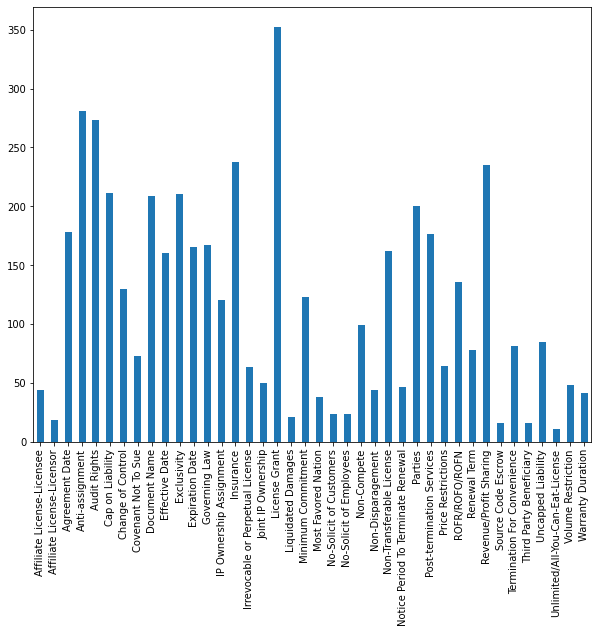

In [8]:
#total clause counts for different labels
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

labels.sum(axis=0).plot.bar()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


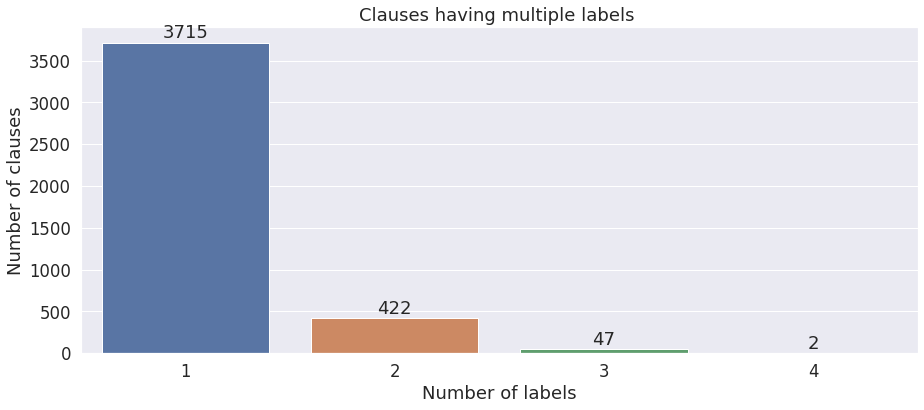

In [9]:
# Counting the number of clauses having multiple labels

rowSums = dataframe.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
sns.set(font_scale =1.5)
plt.figure(figsize=(15,6))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Clauses having multiple labels ")
plt.ylabel('Number of clauses', fontsize=18) 
plt.xlabel('Number of labels', fontsize=18)
#adding the text labels
rects = ax.patches
labels_ = multiLabel_counts.values
for rect, label in zip(rects, labels_):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [10]:
#data pre-processing
def preprocess(sen):
    
    snowball = SnowballStemmer(language='english')


    # # Remove all the special characters
    document = re.sub(r'\W', ' ', str(sen))

    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)

    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)

    # Converting to Lowercase
   # document = document.lower()
    
    

    # Steamming
    document = document.split()

    document = [snowball.stem(word) for word in document]
    
    #Remove stop words
    #document = [word for word in document if not word in stopwords.words()]
    
    document = ' '.join(document)
    return document

In [11]:
sentences = list(dataframe["Clause"])
docs = []
for sen in sentences:
    docs.append(preprocess(sen))
docs

['outsourc technolog develop agreement',
 'document secur system inc dss hotapp intern ltd develop hotapp intern ltd dss document secur system inc',
 '1s day of march 2018',
 'the initi term of this agreement shall commenc on the effect date and shall continu thereaft for period of twelv 12 month the initi term',
 'the initi term shall automat renew for one month period thereaft unless either parti provid 30 day advanc notic of termin unless earlier termin pursuant to section 2 2 hereof',
 'the initi term shall automat renew for one month period thereaft unless either parti provid 30 day advanc notic of termin unless earlier termin pursuant to section 2 2 hereof',
 'this agreement shall be govern in accord with the law of the state of new york without regard to conflict of law principl',
 'either parti may termin this agreement prior to expir of the term upon thirti 30 day prior written notic or ii immedi upon written notic to the other parti if the other parti declar or petit is file 

In [12]:
#split data into train and test
X = docs
y = labels.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [13]:

#tf-idf word embedding
def tfidf_we(train, test):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_feature_train = tfidf.fit_transform(train)
    tfidf_feature_test = tfidf.transform(test)
    return tfidf_feature_train, tfidf_feature_test, tfidf

In [14]:
#BERT word embedding
def get_average_embedding(input_embeddings):
    temp = input_embeddings[0].detach().numpy()
    return np.mean(temp, axis=0)

def get_LEGALBERT_embedding(input_seq, tokenizer, model, **kwargs):
    inputs = tokenizer(input_seq, return_tensors="pt",padding=True, truncation=True,max_length=512, add_special_tokens = True)
    outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    
    if kwargs.get("avg") == 'yes':
        return get_average_embedding(last_hidden_states) #prosek hidden states svih tokena
    #hidden state [CLS] tokena    
    return last_hidden_states[0][0].detach().numpy()

def legal_bert_we(X_train_docs, X_test_docs):
    tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
    model = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")
    X_train_bert = np.array([get_LEGALBERT_embedding(txt, tokenizer, model) for txt in X_train_docs])
    X_test_bert = np.array([get_LEGALBERT_embedding(txt, tokenizer, model) for txt in X_test_docs])
    return X_train_bert, X_test_bert

In [15]:
def glove_embedding_matrix(file_path, vocab_size, tokenizer):
    embeddings_dictionary = dict()

    glove_file = open(file_path, encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = np.zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
    return embedding_matrix

In [16]:
X_train_tfidf, X_test_tfidf, tfidf = tfidf_we(X_train, X_test)
X_train_tfidf.toarray(), X_test_tfidf.toarray()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.10169744, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]))

In [17]:
X_train_bert, X_test_bert = legal_bert_we(X_train, X_test)
X_train_bert

array([[ 0.32007116,  0.03590285,  0.5322243 , ...,  0.13508621,
         0.2588936 ,  0.10578267],
       [ 0.44567022,  0.19642149,  0.5349658 , ..., -0.13175774,
         0.60396   ,  0.20496921],
       [ 0.47410095, -0.17983203,  0.24270427, ..., -0.15225257,
         0.00217616, -0.16678959],
       ...,
       [-0.06859484, -0.09879585,  0.9992294 , ...,  0.93338585,
         0.31512836, -0.00109276],
       [-0.07328441, -0.5417804 , -0.35719106, ...,  0.34447655,
        -0.0791367 , -0.04253463],
       [ 0.37947762, -0.14197187,  0.55721694, ...,  0.05424288,
        -0.3155089 ,  0.21191148]], dtype=float32)

In [18]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [25]:
#Grid search functions
def grid_search_svc(x,y):
    model_to_set = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
    parameters = {
    "estimator__dual": [False, True],
    "estimator__C": [1,4,8,10,100],
    "estimator__fit_intercept": [True, False],
    }
    gs = GridSearchCV(estimator=model_to_set, param_grid=parameters, cv = 5, scoring="f1_micro")
    gs.fit(x, y)
    print(gs.best_score_)
    print(gs.best_params_)
    return gs.best_estimator_

def grid_search_knn(x,y):
    k_range = list(range(1, 31))
    parameters = dict(n_neighbors=k_range)
    
    gs = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=parameters, cv = 5, scoring="f1_micro")
    gs.fit(x, y)
    print(gs.best_score_)
    print(gs.best_params_)
    return gs.best_estimator_

def grid_search_dectree(x,y):
    parameters = {'criterion':['gini','entropy'],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]}
    gs = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=parameters, cv = 5, scoring="f1_micro")
    gs.fit(x, y)
    print(gs.best_score_)
    print(gs.best_params_)
    return gs.best_estimator_

def grid_search_xgboost(x,y):
    model_to_set = OneVsRestClassifier(XGBClassifier(silent=False, colsample_bytree=0.8, subsample=0.8), n_jobs=-1)
    parameters = {
      'estimator__n_estimators': [100, 500],
      'estimator__learning_rate': [0.05, 0.1],
      'estimator__min_child_weight': [1, 5],
      'estimator__gamma': [0.5, 10],
      'estimator__max_depth': [3, 20],
      'estimator__tree_method': ['gpu_hist'],
      'estimator__nthread': [-1],
    }
    dfx = pd.DataFrame(x)
    x_train, x_val, y_train, y_val = train_test_split(dfx, y, train_size = 0.8,random_state = 2020)
    split_index = [-1 if row in x_train.index else 0 for row in dfx.index]
    print(split_index)
    pds = PredefinedSplit(test_fold = split_index)
    gs = GridSearchCV(estimator=model_to_set, param_grid=parameters, cv = pds, scoring="f1_micro", verbose=3)
    gs.estimator.get_params().keys()
    gs.fit(x, y)
    print(gs.best_score_)
    print(gs.best_params_)
    return gs.best_estimator_, gs.best_params_

def create_model_rnn():
    deep_inputs = Input(shape=(maxlen,))
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
    LSTM_Layer_1 = LSTM(128)(embedding_layer)
    dense_layer_1 = Dense(40, activation='sigmoid')(LSTM_Layer_1)
    model = Model(inputs=deep_inputs, outputs=dense_layer_1)

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
    return model

def grid_search_rnn(X,Y):

  # create model
  c_model = KerasClassifier(build_fn=create_model_rnn)
  # define the grid search parameters
  batch_sizes = [16, 32, 64, 128]
  epochs = [10, 100, 200]
  parameters = {'batch_size': batch_sizes, 'epochs': epochs}
  print(parameters)
  grid = GridSearchCV(estimator=c_model, param_grid=parameters)
  grid_result = grid.fit(X, Y)

  print(grid_result.best_score_)
  print(grid_result.best_params_)

  return grid_result.best_estimator_ 

In [19]:
ModelsPerformance = {}
def metricsReport(modelName, test_labels, predictions):
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    micro_f1 = f1_score(test_labels, predictions, average='micro')
    
    jaccard = jaccard_score(test_labels, predictions, average = 'micro')
    
    hamLoss = hamming_loss(test_labels, predictions)
    ModelsPerformance[modelName] = micro_f1

In [ ]:
#SVC grid search
svmClassifier = grid_search_svc(X_train_tfidf.toarray(), y_train)
svmClassifier

0.7438778264120676
{'estimator__C': 10, 'estimator__dual': False, 'estimator__fit_intercept': True}


OneVsRestClassifier(estimator=LinearSVC(C=10, class_weight=None, dual=False,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=None, tol=0.0001,
                                        verbose=0),
                    n_jobs=-1)

In [ ]:
svmPreds = svmClassifier.predict(X_test_tfidf.toarray())
metricsReport("Linear SVC", y_test, svmPreds)

In [ ]:
#KNN grid search
knnClf = grid_search_knn(X_train_tfidf.toarray(), y_train)
knnClf

0.5899308717320126
{'n_neighbors': 3}


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
knnPreds = knnClf.predict(X_test_tfidf.toarray())

In [ ]:
#Decision tree grid search
decTreeClf = grid_search_dectree(X_train_tfidf.toarray(), y_train)
decTreeClf

0.6486839687319643
{'criterion': 'gini', 'max_depth': 50}


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
dtPreds = knnClf.predict(X_test_tfidf.toarray())
metricsReport("Decision tree", y_test, dtPreds)

In [ ]:
ModelsPerformance

{'Decision tree': 0.5980830670926518,
 'KNN': 0.5980830670926518,
 'Linear SVC': 0.775462962962963}

In [ ]:
#XGB Boost grid search
xgBoostClf, xgBoostParams = grid_search_xgboost(X_train_tfidf.toarray(), y_train)
xgBoostClf, xgBoostParams

[-1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, -1, -1, 0, -1, -1, -1, 0, -1, -1, -1, 0, 0, 0, -1, 0, -1, 0, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0, -1, 0, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1, 0, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, 0, 0, -1, -1, 0, -1, 0, -1, -1, -1, -1, 0, -1, -1, -1, -1, 0, -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.700, total= 3.5min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.5min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.736, total=10.9min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 14.4min remaining:    0.0s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.660, total= 3.6min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.694, total=10.5min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.724, total= 4.9min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.729, total=15.1min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.686, total= 4.1min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.702, total=13.0min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.731, total= 3.6min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.731, total=10.5min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.687, total= 3.4min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.683, total=10.2min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.730, total= 4.7min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.734, total=13.9min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.703, total= 4.1min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.692, total=12.4min
[CV] estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.700, total= 3.5min
[CV] estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.736, total=10.8min
[CV] estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.660, total= 3.5min
[CV] estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.694, total=10.4min
[CV] estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.724, total= 4.9min
[CV] estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.729, total=15.0min
[CV] estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.686, total= 4.2min
[CV] estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.702, total=12.9min
[CV] estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.731, total= 3.4min
[CV] estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.731, total=10.6min
[CV] estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.687, total= 3.5min
[CV] estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.683, total=10.2min
[CV] estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.730, total= 4.7min
[CV] estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.734, total=13.9min
[CV] estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.703, total= 4.0min
[CV] estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=10, estimator__learning_rate=0.1, estimator__max_depth=20, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.692, total=12.3min


[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 256.3min finished
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.7358062074186223
{'estimator__gamma': 0.5, 'estimator__learning_rate': 0.05, 'estimator__max_depth': 3, 'estimator__min_child_weight': 1, 'estimator__n_estimators': 500, 'estimator__nthread': -1, 'estimator__tree_method': 'gpu_hist'}


(OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0.5,
                                             learning_rate=0.05,
                                             max_delta_step=0, max_depth=3,
                                             min_child_weight=1, missing=None,
                                             n_estimators=500, n_jobs=1,
                                             nthread=-1,
                                             objective='binary:logistic',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                             seed=None, silent=False,
                                             subsample=1, tree_meth

In [ ]:
#XGB Boost+bert grid search 
xgBoostClfBert, xgBoostParamsBert = grid_search_xgboost(X_train_bert, y_train)
xgBoostClfBert, xgBoostParamsBert

[-1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, -1, -1, 0, -1, -1, -1, 0, -1, -1, -1, 0, 0, 0, -1, 0, -1, 0, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 0, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, 0, -1, 0, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1, -1, 0, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, 0, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, -1, -1, -1, 0, -1, 0, -1, -1, -1, -1, 0, -1, -1, -1, -1, 0, -1, -1, -1, -1, -1, 0, -1, 0, 0, -1, -1, 0, -1, 0, -1, -1, -1, -1, 0, -1, -1, -1, -1, 0, -

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.375, total= 1.3min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=1, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.497, total= 4.4min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.6min remaining:    0.0s


[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.378, total= 1.2min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist 
[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=3, estimator__min_child_weight=5, estimator__n_estimators=500, estimator__nthread=-1, estimator__tree_method=gpu_hist, score=0.505, total= 4.2min
[CV] estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=100, estimator__nthread=-1, estimator__tree_method=gpu_hist 
[CV]  estimator__gamma=0.5, estimator__learning_rate=0.05, estimator__max_depth=20, estimator__min_child_weight=1, estimator__n_estimators=100, estimat

[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed: 109.9min finished


0.5096952908587258
{'estimator__gamma': 0.5, 'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__min_child_weight': 5, 'estimator__n_estimators': 500, 'estimator__nthread': -1, 'estimator__tree_method': 'gpu_hist'}


(OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0.5,
                                             learning_rate=0.1, max_delta_step=0,
                                             max_depth=3, min_child_weight=5,
                                             missing=None, n_estimators=500,
                                             n_jobs=1, nthread=-1,
                                             objective='binary:logistic',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                             seed=None, silent=False,
                                             subsample=1, tree_method='gpu_hist',
                               

In [ ]:
xgbPredsBert = xgBoostClfBert.predict(X_test_bert)
metricsReport("XGBoost-BERT", y_test, xgbPredsBert)
ModelsPerformance

{'XGBoost-BERT': 0.5212298682284041}

In [ ]:
xgbPreds = xgBoostClf.predict(X_test_tfidf.toarray())
metricsReport("XGBoost-tf-idf", y_test, xgbPreds)
ModelsPerformance

{'XGBoost-tf-idf': 0.767497034400949}

In [20]:
def train_svm_with_best_params(X_train, y_train):
  svmClassifier = OneVsRestClassifier(estimator=LinearSVC(C=10, class_weight=None, dual=False,
                                          fit_intercept=True, intercept_scaling=1,
                                          loss='squared_hinge', max_iter=1000,
                                          multi_class='ovr', penalty='l2',
                                          random_state=None, tol=0.0001,
                                          verbose=0),n_jobs=-1)
  svmClassifier.fit(X_train, y_train)
  return svmClassifier

def train_knn_with_best_params(X_train, y_train):
  knnClf = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')
  knnClf.fit(X_train, y_train)
  return knnClf

def train_decision_tree_with_best_params(X_train, y_train):
  dtClf = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=50, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
  dtClf.fit(X_train, y_train)
  return dtClf

def train_xgb_with_best_params_tf_idf(X_train, y_train):
  xgbClf = OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0.5,
                                             learning_rate=0.05,
                                             max_delta_step=0, max_depth=3,
                                             min_child_weight=1, missing=None,
                                             n_estimators=500, n_jobs=1,
                                             nthread=-1,
                                             objective='binary:logistic',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                             seed=None, silent=False,
                                             subsample=1, tree_method='gpu_hist',
                                             verbosity=1), n_jobs=-1)
  xgbClf.fit(X_train, y_train)
  return xgbClf

def train_xgb_with_best_params_bert(X_train, y_train):
  xgbClf = OneVsRestClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0.5,
                                             learning_rate=0.1, max_delta_step=0,
                                             max_depth=3, min_child_weight=5,
                                             missing=None, n_estimators=500,
                                             n_jobs=1, nthread=-1,
                                             objective='binary:logistic',
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                                             seed=None, silent=False,
                                             subsample=1, tree_method='gpu_hist',
                                             verbosity=1), n_jobs=-1)
  xgbClf.fit(X_train, y_train)
  return xgbClf



In [21]:
svmClf_bp = train_svm_with_best_params(X_train_tfidf.toarray(), y_train)
svmPreds_bp = svmClf_bp.predict(X_test_tfidf.toarray())
metricsReport("Linear SVC", y_test, svmPreds_bp)

In [22]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

oversample = SMOTE(kind='regular',k_neighbors=2)
X_over, y_over = oversample.fit_resample(X_train_tfidf.toarray(), y_train)
svcClf_oversample = train_svm_with_best_params(X_over, y_over)
svcClfPreds_oversample = svcClf_oversample.predict(X_test_tfidf.toarray())
metricsReport("Linear SVC With Oversampling", y_test, svcClfPreds_oversample)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

In [23]:
knnClf_bp = train_knn_with_best_params(X_train_tfidf.toarray(), y_train)
knnPreds_bp = knnClf_bp.predict(X_test_tfidf.toarray())
metricsReport("KNN", y_test, knnPreds_bp)

In [24]:
dtClf_bp = train_decision_tree_with_best_params(X_train_tfidf.toarray(), y_train)
dtPreds_bp = dtClf_bp.predict(X_test_tfidf.toarray())
metricsReport("Decision tree", y_test, dtPreds_bp)

In [25]:
xgbClf_bp_tfidf = train_xgb_with_best_params_tf_idf(X_train_tfidf.toarray(), y_train);
xgbPreds_bp_tfidf = xgbClf_bp_tfidf.predict(X_test_tfidf.toarray())
metricsReport("XGBoost-tf-idf", y_test, xgbPreds_bp_tfidf)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [26]:
xgbClf_bp_bert = train_xgb_with_best_params_bert(X_train_bert, y_train);
xgbPreds_bp_bert = xgbClf_bp_bert.predict(X_test_bert)
metricsReport("XGBoost-bert", y_test, xgbPreds_bp_bert)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [27]:
ModelsPerformance

{'Decision tree': 0.6540389972144847,
 'KNN': 0.5867875647668394,
 'Linear SVC': 0.7533064979873489,
 'Linear SVC With Oversampling': 0.7136829415310426,
 'XGBoost-bert': 0.4996237772761475,
 'XGBoost-tf-idf': 0.7406513872135102}

In [ ]:
#RNN
fp = './glove.6B.100d.txt'

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_tr = tokenizer.texts_to_sequences(X_train)
X_te = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200
embedding_matrix = glove_embedding_matrix(fp, vocab_size, tokenizer)




In [ ]:
X_tre = pad_sequences(X_tr, padding='post', maxlen=maxlen)
X_tes = pad_sequences(X_te, padding='post', maxlen=maxlen)
lstm_par = grid_search_rnn(X_tre, y_train)

Streaming output truncated to the last 5000 lines.
42/42 [==============================] - 1s 22ms/step - loss: 0.0944 - acc: 0.2307 - f1_m: 0.0871 - precision_m: 0.6863 - recall_m: 0.0470
Epoch 62/200
42/42 [==============================] - 1s 22ms/step - loss: 0.0934 - acc: 0.2416 - f1_m: 0.0981 - precision_m: 0.7273 - recall_m: 0.0544
Epoch 63/200
42/42 [==============================] - 1s 22ms/step - loss: 0.0939 - acc: 0.2470 - f1_m: 0.0708 - precision_m: 0.7189 - recall_m: 0.0378
Epoch 64/200
42/42 [==============================] - 1s 21ms/step - loss: 0.0950 - acc: 0.2232 - f1_m: 0.0677 - precision_m: 0.8162 - recall_m: 0.0359
Epoch 65/200
42/42 [==============================] - 1s 22ms/step - loss: 0.0921 - acc: 0.2524 - f1_m: 0.1021 - precision_m: 0.7433 - recall_m: 0.0558
Epoch 66/200
42/42 [==============================] - 1s 23ms/step - loss: 0.0905 - acc: 0.2501 - f1_m: 0.1313 - precision_m: 0.6452 - recall_m: 0.0755
Epoch 67/200
42/42 [==============================

In [ ]:
X_tre = pad_sequences(X_tr, padding='post', maxlen=maxlen)
X_tes = pad_sequences(X_te, padding='post', maxlen=maxlen)

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(40, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
history = model.fit(X_tre, y_train, batch_size=16, epochs=200, verbose=1, validation_split=0.2)

Epoch 1/200
168/168 [==============================] - 35s 16ms/step - loss: 0.2929 - acc: 0.0449 - f1_m: 0.0252 - precision_m: 0.0191 - recall_m: 0.0411 - val_loss: 0.1209 - val_acc: 0.0597 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 2/200
168/168 [==============================] - 2s 12ms/step - loss: 0.1214 - acc: 0.0591 - f1_m: 5.8745e-04 - precision_m: 4.2640e-04 - recall_m: 9.4809e-04 - val_loss: 0.1217 - val_acc: 0.0642 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 3/200
168/168 [==============================] - 2s 12ms/step - loss: 0.1220 - acc: 0.0566 - f1_m: 5.7502e-05 - precision_m: 4.0970e-05 - recall_m: 9.6400e-05 - val_loss: 0.1216 - val_acc: 0.0746 - val_f1_m: 0.0000e+00 - val_precision_m: 0.0000e+00 - val_recall_m: 0.0000e+00
Epoch 4/200
168/168 [==============================] - 2s 12ms/step - loss: 0.1211 - acc: 0.0732 - f1_m: 2.1950e-05 - precision_m: 1.5640e-05 - recall_m: 3.6799e-05 

In [ ]:
score = model.evaluate(X_tes, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("f1 score:", score[2])
print("Precision:", score[3])
print("Recall:", score[4])

27/27 [==============================] - 0s 9ms/step - loss: 0.1188 - acc: 0.5668 - f1_m: 0.6122 - precision_m: 0.6696 - recall_m: 0.5690
Test Score: 0.11883347481489182
Test Accuracy: 0.5668257474899292
f1 score: 0.6122166514396667
Precision: 0.6695505976676941
Recall: 0.5689561367034912


In [ ]:
# save rnn model
# import pickle
# with open('saved_tokenizer.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# model_json = model.to_json()
# with open("saved_model.json", "w") as json_file:
#     json_file.write(model_json)

In [ ]:
# model.save_weights("saved_model.h5")

In [ ]:
#load rnn model
json_file = open(r'./saved_model.json', 'r')
model_json = json_file.read()
json_file.close()
model_ = model_from_json(model_json)
model_.load_weights(r'./saved_model.h5')

In [ ]:
model_.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc',f1_m,precision_m, recall_m])
score = model_.evaluate(X_tes, y_test, verbose=1)

27/27 [==============================] - 1s 9ms/step - loss: 0.1115 - acc: 0.5685 - f1_m: 0.6164 - precision_m: 0.6557 - recall_m: 0.5839


In [ ]:
# print("Test Score:", score[0])
# print("Test Accuracy:", score[1])
# print("f1 score:", score[2])
# print("Precision:", score[3])
# print("Recall:", score[4])

Test Score: 0.11883347481489182
Test Accuracy: 0.5668257474899292
f1 score: 0.6122166514396667
Precision: 0.6695505976676941
Recall: 0.5689561367034912


In [ ]:
# from google.colab import files
# files.download('saved_tokenizer.pickle')
# files.download('saved_model.json')
# files.download('saved_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# import pickle

# # save classfier
# filename = 'finalized_model.sav'
# pickle.dump(knnClf, open(filename, 'wb'))

# # save classfier
# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.score(tfidf_feature_test, y_test)
# result

In [32]:
#pokrenuti za ucitavanje pdf-a
from google.colab import files
uploaded = files.upload()

Saving CHIPMOSTECHNOLOGIESBERMUDALTD_04_18_2016-EX-4.72-Strategic Alliance Agreement.PDF to CHIPMOSTECHNOLOGIESBERMUDALTD_04_18_2016-EX-4.72-Strategic Alliance Agreement.PDF
Saving CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605784_EX-10.27_Affiliate Agreement.pdf to CybergyHoldingsInc_20140520_10-Q_EX-10.27_8605784_EX-10.27_Affiliate Agreement.pdf
Saving FuelcellEnergyInc_20191106_8-K_EX-10.1_11868007_EX-10.1_Development Agreement.pdf to FuelcellEnergyInc_20191106_8-K_EX-10.1_11868007_EX-10.1_Development Agreement.pdf
Saving KIROMICBIOPHARMA,INC_04_08_2020-EX-10.28-JOINT VENTURE AGREEMENT.PDF to KIROMICBIOPHARMA,INC_04_08_2020-EX-10.28-JOINT VENTURE AGREEMENT.PDF
Saving PapaJohnsInternationalInc_20190617_8-K_EX-10.1_11707365_EX-10.1_Endorsement Agreement.pdf to PapaJohnsInternationalInc_20190617_8-K_EX-10.1_11707365_EX-10.1_Endorsement Agreement (1).pdf
Saving VirtuosoSurgicalInc_20191227_1-A_EX1A-6 MAT CTRCT_11933379_EX1A-6 MAT CTRCT_License Agreement.pdf to VirtuosoSurgicalInc_201912

In [28]:
##Example of models usage on full contracts in pdf
!pip install pdfminer
!pip install unidecode
import nltk
from nltk import tokenize
nltk.download('punkt')
import unidecode
import spacy
from io import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage

     |████████████████████████████████| 4.2MB 6.9MB/s 
     |████████████████████████████████| 1.9MB 55.4MB/s 
  Created wheel for pdfminer: filename=pdfminer-20191125-cp37-none-any.whl size=6140083 sha256=b003595e4f190159372653aabf1fbb7a4585f7cc276446161831dda04ab1fc72
  Stored in directory: /root/.cache/pip/wheels/e1/00/af/720a55d74ba3615bb4709a3ded6dd71dc5370a586a0ff6f326
Successfully built pdfminer
     |████████████████████████████████| 245kB 7.7MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [29]:
def convert(fname, pages=None):
    if not pages:
        pagenums = set()
    else:
        pagenums = set(pages)

    output = StringIO()
    manager = PDFResourceManager()
    converter = TextConverter(manager, output, laparams=LAParams())
    interpreter = PDFPageInterpreter(manager, converter)

    infile = open(fname, 'rb')
    for page in PDFPage.get_pages(infile, pagenums):
        interpreter.process_page(page)
    infile.close()
    converter.close()
    text = output.getvalue()
    output.close
    return text
    
def preprocess_pdf_nltk(file_path):
  text_from_pdf = convert(file_path) 
  text = tokenize.sent_tokenize(text_from_pdf)
  sentences = []

  #
  for sentence in text:
      sentences.append(unidecode.unidecode(sentence))

  preprocessed = []
  for sentence in sentences:
      preprocessed.append(preprocess(sentence))
  
  return sentences, preprocessed

def preprocess_pdf_spacy(file_path):
  nlp = spacy.load('en')

  text_from_pdf = convert(file_path) 
  tokens = nlp(text_from_pdf)

  preprocessed = []
  sentences = []
  for sent in tokens.sents:
      sentences.append(sent)
      preprocessed.append(preprocess(sent))
  return sentences, preprocessed

def classify_pdf_clauses(file_path, labels, use_nltk):
  if use_nltk:
    sentences, preprocessed = preprocess_pdf_nltk(file_path)
  else:
    sentences, preprocessed = preprocess_pdf_spacy(file_path)
  tfidf_feature_pdf = tfidf.transform(preprocessed)
  y_pred_pdf_svm = svmClf_bp.predict(tfidf_feature_pdf.toarray())
  y_pred_pdf_xgb = xgbClf_bp_tfidf.predict(tfidf_feature_pdf.toarray())
  for i in range(len(sentences)):
    if ((np.sum(y_pred_pdf_svm[i])>0) or (np.sum(y_pred_pdf_xgb[i])>0)):
      print()
      print(i)
      print(sentences[i])
      # print(y_pred_pdf[i])
      for j in range(len(labels)):
        if y_pred_pdf_svm[i][j] == 1:
          print("SVM: ", labels[j])
        if y_pred_pdf_xgb[i][j] == 1:
          print("XGB: ", labels[j])

In [ ]:
###USING RNN

# tes = tokenizer.texts_to_sequences(sentences)
# tes = pad_sequences(tes, padding='post', maxlen=maxlen)

In [ ]:
# res = model.predict(tes)
# res = res.round()
# print(res)

In [ ]:
# for el in res:
#   print(el)

In [33]:
labels = ['Affiliate License-Licensee', 'Affiliate License-Licensor',
       'Agreement Date', 'Anti-assignment', 'Audit Rights', 'Cap on Liability',
       'Change of Control', 'Covenant Not To Sue', 'Document Name',
       'Effective Date', 'Exclusivity', 'Expiration Date', 'Governing Law',
       'IP Ownership Assignment', 'Insurance',
       'Irrevocable or Perpetual License', 'Joint IP Ownership',
       'License Grant', 'Liquidated Damages', 'Minimum Commitment',
       'Most Favored Nation', 'No-Solicit of Customers',
       'No-Solicit of Employees', 'Non-Compete', 'Non-Disparagement',
       'Non-Transferable License', 'Notice Period To Terminate Renewal',
       'Parties', 'Post-termination Services', 'Price Restrictions',
       'ROFR/ROFO/ROFN', 'Renewal Term', 'Revenue/Profit Sharing',
       'Source Code Escrow', 'Termination For Convenience',
       'Third Party Beneficiary', 'Uncapped Liability',
       'Unlimited/All-You-Can-Eat-License', 'Volume Restriction',
       'Warranty Duration']

       
local_pdf_filename = "PapaJohnsInternationalInc_20190617_8-K_EX-10.1_11707365_EX-10.1_Endorsement Agreement.pdf"
classify_pdf_clauses(local_pdf_filename, labels, True)


0
Exhibit 10.1ENDORSEMENT AGREEMENTTHIS ENDORSEMENT AGREEMENT ("Agreement") is made and entered into effective March 15, 2019 (the "Effective Date") by andamong, on the one hand, ABG-Shaq, LLC, a Delaware limited liability company ("ABG") for the personal services of Shaquille O'Neal,("CELEBRITY"), and, on the other hand, Papa John's Marketing Fund, Inc., a Kentucky corporation ("PJMF"), and Papa John's International, Inc.("PJI") (PJMF and PJI are, individually and collectively, "PAPA JOHN'S").
SVM:  Parties

1
ABG and PAPA JOHN'S may hereinafter be referred to individually as a"Party" or collectively as the "Parties".WITNESSETH:WHEREAS, CELEBRITY is recognized and known for his skills as an athlete, sports analyst, and celebrity personality?WHEREAS, ABG, as successor in interest to CELEBRITY, is the exclusive rights holder throughout the world of certain rights toCELEBRITY'S name, image, and services, and has the authority to exploit such rights?WHEREAS, PJMF is a corporation that pa